In [4]:
from collections import namedtuple
import glob
from itertools import product
import json
import logging
import math
import os
import random

import soundfile as sf
from pyrubberband import pyrb
import argparse
import librosa.effects
import librosa.core
import librosa.output
import numpy as np
import pydub
import scipy.fftpack
import tensorflow as tf
tf.enable_v2_behavior()

from tqdm.notebook import trange, tqdm

from audio_load import load_audio_from_files, audio2spec
import augment_audio as aa
from st_2d import scat2d
import windows as win

In [5]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [6]:
import importlib

In [654]:
importlib.reload(aa)

<module 'augment_audio' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/augment_audio.py'>

In [3]:
sr=16000

In [4]:
def load_data(p_files):    
    
    p_samples = load_audio_from_files(p_files, "wav", 3000, 8000)
    p_specs = audio2spec(p_samples, 160, 80, 640)
    p_labels = np.ones(len(p_samples))
    
    return p_samples, p_specs, p_labels

In [5]:
# load negative source files
n_files = glob.glob('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-360/*/*/*.flac')
len(n_files)

104014

In [6]:
# load positive source files, with metadata
with open('data/alexa.annotated.json') as json_file:
    positive_metadata = json.load(json_file)
source_files_ = list(positive_metadata.keys())
source_files = [os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', fname) for fname in source_files_]

In [7]:
def filter_for_speech(samples, sr=sr, low_freq=85, hi_freq=255):
    samples = (samples * 2**15).astype(np.int16)
    sound = pydub.AudioSegment(
        samples.tobytes(), 
        frame_rate=sr,
        sample_width=samples.dtype.itemsize, 
        channels=1
    )
    
    sound_hi = pydub.effects.high_pass_filter(sound, low_freq)
    sound_mid = pydub.effects.low_pass_filter(sound_hi, hi_freq)
    y_ = sound_mid.get_array_of_samples()
    y = np.array(y_, dtype=np.float) / np.abs(y_).max()
    return y

## Extract words

In [233]:
from scipy.signal import argrelextrema

In [585]:
def segments_from_loc_minmax(local_maxima, local_minima):
    """
    For each local maxima M, outputs a segment that is a:b where
    a = local minima right before M and b =  local minima right
    after M.
    """
    min_p = 0
    max_p = 0
    

    def ff_max(max_p):
        # get max just ahead of current min
        while max_p < (len(local_maxima) ) and min_p < len(local_minima) and (local_minima[min_p] > local_maxima[max_p]):
            max_p += 1
        return max_p
    
    def ff_min(min_p):
        # get min closest and before to current max
        while min_p < (len(local_minima) -1 ) and (local_minima[min_p+1] < local_maxima[max_p]):
            min_p += 1
        return min_p
    
    intervals = []

    max_p = ff_max(max_p)
    while max_p < len(local_maxima) and min_p < len(local_minima):
        min_p = ff_min(min_p)
        if min_p < (len(local_minima) - 1):
            intervals.append([local_minima[min_p], local_minima[min_p+1]])
        min_p += 1
        max_p = ff_max(max_p)
        
    return intervals
        

In [763]:
# pick a random negative audio file
samples_other_speech, _ = sf.read(n_files[random.randint(0,len(n_files)-1)])

In [816]:
samples_other_speech, _ = sf.read('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-360/1383/130532/1383-130532-0017.flac')

In [829]:
ipd.Audio(samples_other_speech, rate=sr)

In [817]:
samples_filtered = filter_for_speech(samples_other_speech)

In [818]:
samples_normed = aa.scale_to_peak_windowed_dBFS(samples_filtered, target_dBFS=-20.0)

In [819]:
frame_length = int(sr * 0.1)
hop_length = frame_length//4
top_db = 35
low_db = 45
min_length_s = 0.35
max_length_s = 1.2

In [820]:
win = librosa.filters.get_window('hann', frame_length, fftbins=False)
win = win / win.sum()
y = np.convolve( np.power(samples_normed, 2), win, 'same')

In [821]:
speech_db = librosa.core.power_to_db(y)

In [823]:
top_db = np.median(speech_db)
low_db = np.median(speech_db)


In [824]:
# built in equivalent not very good...
# intervals = librosa.effects.split(samples_normed, top_db=top_db, frame_length=frame_length, hop_length=hop_length, ref=1.0)
# intervals = [pair for pair in intervals if (pair[1] - pair[0])/sr > min_length_s and (pair[1] - pair[0])/sr < max_length_s]
# len(intervals)

In [830]:
local_minima = argrelextrema(speech_db, np.less, order=1)[0]
local_maxima = argrelextrema(speech_db, np.greater, order=1)[0]

quiet_loc = []
for idx in local_minima:
    if speech_db[idx] < low_db:
        quiet_loc.append(idx)
loud_loc = []
for idx in local_maxima:
    if speech_db[idx] > top_db:
        loud_loc.append(idx)
quiet_loc = [0] + quiet_loc + [len(quiet_loc)-1]
intervals = segments_from_loc_minmax(loud_loc, quiet_loc)

len(intervals)

6

In [826]:
# concatenate neighboring ones if too short and close together
p_ = 0
while p_ < len(intervals):
    curr = intervals[p_]
    if (curr[1] - curr[0])/sr > max_length_s:
        # too long, throw away
        intervals.pop(p_)
    elif (curr[1] - curr[0])/sr < min_length_s:
        # too short, concat with next if ok
        if p_ < (len(intervals) - 1) and intervals[p_+1][0] - curr[1] < 0.05*sr:
            next_ = intervals.pop(p_+1)
            intervals[p_][1] = next_[1]
        else:
            intervals.pop(p_)
    else:
        # is fine, continue
        p_ += 1
len(intervals)

0

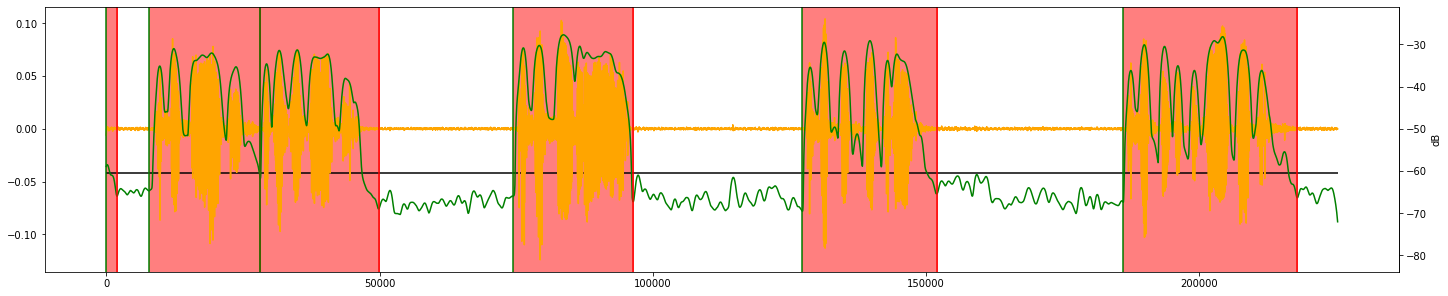

In [831]:
fig, ax = plt.subplots(constrained_layout=True)

# 50 / scaling = max
scaling = 250.0

def pm1_to_dB(s):
    # put -1,1 into -100,0 db
    return s*scaling - 50

def dB_to_pm1(s):
    # put -100,0 db into -1,1
    return (s + 50) / scaling

plt.plot(samples_normed, 'orange')
plt.plot(dB_to_pm1(speech_db), 'green')

    
secaxy = ax.secondary_yaxis('right', functions=(pm1_to_dB, dB_to_pm1))
secaxy.set_ylabel('dB')

for interval in intervals:
    s, e = interval
    plt.axvline(e, 0,1, color='red')
    plt.axvline(s, 0,1, color='green')

    ax.axvspan(s, e, alpha=0.5, color='red')

    
# for t in quiet_loc:
#     plt.axvline(t, 0,1, color='blue')

# for t in loud_loc:
#     plt.axvline(t, 0,1, color='red')


plt.hlines(dB_to_pm1(top_db), 0, len(samples_normed))
fig.set_figwidth(20)

In [828]:
# append the words ju
words = []
intervals = sorted(intervals, key=lambda pair: speech_db[pair[0]] + speech_db[pair[1]])
for interval in intervals:
    s, e = interval
#     if (e-s) > 0.3*sr:
#     s -= hop_length
#     e += hop_length
    #     e = max(e, s+sr//2)
    #     e = min(e, s+ sr)
    words.append(samples_other_speech[s:e])

# random.shuffle(words)
words_with_silence = []
for word in words:
    words_with_silence.append(word)
    words_with_silence.append(np.zeros(sr))

as_word = np.concatenate(words_with_silence)

ValueError: need at least one array to concatenate

In [752]:
len(as_word)

521420

In [753]:
ipd.Audio(as_word, rate=sr)

In [774]:
# p_file
p_file = source_files[10]
p_start_end = positive_metadata[source_files_[10]]

In [808]:
example_length = 5*sr

silence_max = 0.6
silence_min = 0.1
loudness = 1.0
target_dBFS = -10.0

In [809]:
# mix some audio with the wakeword
wakeword_samples, _ = sf.read(p_file)
wakeword = aa.Clip(wakeword_samples, *p_start_end)
cur_dBFS = aa.peak_windowed_dBFS(wakeword.samples[wakeword.start:wakeword.end])
a = aa.scaling_for_dBFS_change(cur_dBFS, target_dBFS)
wakeword = aa.Clip(a*wakeword.samples, wakeword.start, wakeword.end)


In [810]:
# intervals = wordlike_split(normed_oth)
output = np.zeros((example_length,3))
labs = np.zeros((example_length,3))
# flip a coin until wakeword
t = 0
inserted_wakeword = False
interval_p = 0
silence_last = False
while t < example_length and interval_p < len(intervals):
        intvs, intve = intervals[interval_p]
        intv_len = intve - intvs
        # first insert silence
        if not silence_last:
            t += int(np.random.uniform(silence_min, silence_max) * sr)
            silence_last = True
        # flip a coin until wakeword
        insert_wakeword = random.random() < (t/(4.0*example_length/5))
        if not inserted_wakeword and insert_wakeword:
            # wakeword has padding
            ds = max(0,t - wakeword.start)
            ss = max(0,ds + wakeword.start - t)
            de = min(len(wakeword) - wakeword.start + t, example_length)
            se = min(de - t + wakeword.start, len(wakeword))
            
            output[ds:de,1] = wakeword.samples[ss:se]
            labs[t:(t + wakeword.end - wakeword.start),1] = 1
            silence_last = False
            inserted_wakeword = True
            t += wakeword.end - wakeword.start
        elif t + intv_len < example_length:
            insert = aa.scale_to_peak_windowed_dBFS(samples_other_speech[intvs:intve], target_dBFS=target_dBFS)
            track_idx = int(inserted_wakeword)*2
            output[t:(t+intv_len),track_idx] = (insert - insert.mean())
            labs[t:(t+intv_len),track_idx] = 1
            interval_p += 1
            silence_last = False
            t += intv_len
        else:
            interval_p += 1

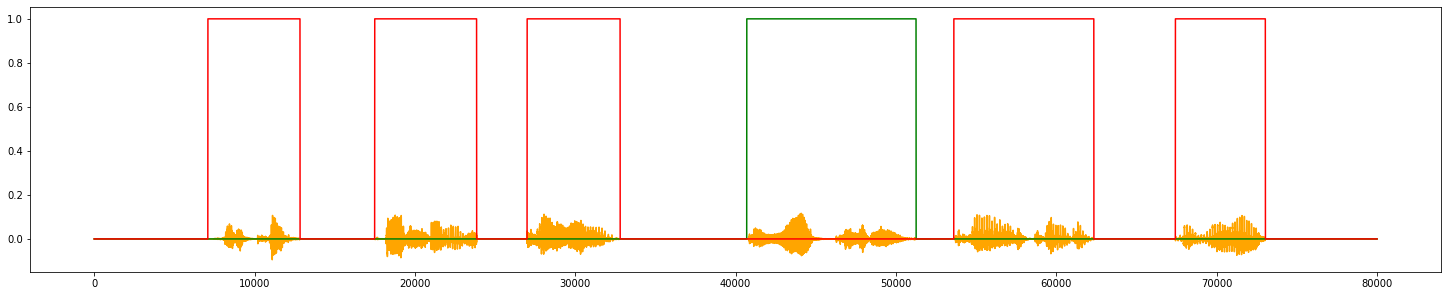

In [811]:
fig, ax = plt.subplots(constrained_layout=True)

plt.plot(output.mean(axis=1), 'orange')
plt.plot(labs[:,1], 'green')
plt.plot(labs[:,0] + labs[:,2], 'red')


fig.set_figwidth(20)

In [812]:
source1 = output.mean(axis=1)
ipd.Audio(source1, rate=sr)

In [813]:
# small room, large room
bedroom = [4.9, 3.6, 3.5]
large_livingroom = [8.5, 6.7, 3.5]
room_dim_opts = [bedroom, large_livingroom]
# absorption small...big
room_absorption_opts = np.arange(0.4,0.9,0.05) # prefer non-echoey rooms

room_sim_opts = list(product(*[room_dim_opts, room_absorption_opts]))

In [814]:
# include gwn
source2 = aa.gwn_for_audio(source1, snr=40)
room_dim, room_absorption = random.sample(room_sim_opts, 1)[0]
source2_distance = 1.0
source1_distance = np.clip(np.random.normal(0.5, 0.1), 0.1, 1.0)

mix = aa.mix_2_sources(source1, source2, room_dim, room_absorption, source1_distance, source2_distance)
mix = mix[:example_length]

In [815]:
ipd.Audio(mix, rate=sr)

## Data alignment

We have access to start/end time of keywords.

For the v3 dataset: clip lengths are 31 context chunks * 1+ frames per chunk
25ms windows with 10ms hops

So 4 frames per chunk means 1240ms clip, looking back 800ms.
Shorter than this seems hard since the whole wakeword may not be present.
But lookahead then is 400ms.

In [12]:
# pick a random negative audio file
samples_bg, _ = sf.read(n_files[random.randint(0,len(n_files)-1)])

In [13]:
ipd.Audio(samples_bg, rate=sr)

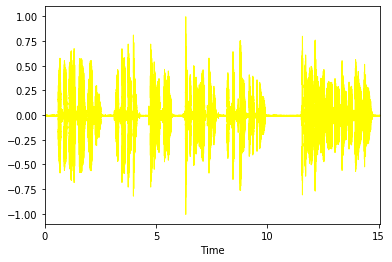

In [15]:
y_ = filter_for_speech(samples_bg)
librosa.display.waveplot(y_, sr=sr, color='yellow')
ipd.Audio(y_, rate=sr)

In [12]:
def pad_clip(clip, padding=(0,0)):
    pad_left, _ = padding
    y = np.pad(clip.samples, pad_width=padding, mode='constant', constant_values=0)
    return Clip(y, clip.start+pad_left, clip.end+pad_left)

def extract_other_speech_padding(samples_bg, length=48000):
    """
    Returns:
      leading Clip and trailing Clip
    """
    # try to figure out start time with filtered speech
    samples_filtered = filter_for_speech(samples_bg)
    audio_chunks = librosa.effects.split(samples_filtered, top_db=20, frame_length=320, hop_length=160)
    audio_chunks_flat = [item for sublist in audio_chunks for item in sublist]
    start = min(audio_chunks_flat)
    end = max(audio_chunks_flat)
    # print(start,len(samples_bg)-end)
    # TODO: check that start/end times are "correct," maybe close enough to front/end
    middle = (end-start) // 2
    
    if end - middle > length:
        lead = Clip(samples_bg, end - length, end)
    else:
        lead = Clip(samples_bg, middle, end)
        lead = pad_clip(lead, (length-(end - middle),0))
    
    if middle - start:
        trail = Clip(samples_bg, start, start + length)
    else:
        trail = Clip(samples_bg, start, middle)
        trail = pad_clip(trail, (0, length - (middle - start)))
        
    return lead, trail

In [13]:
lead, trail = extract_other_speech_padding(samples_bg)

In [14]:
# pick a random positive example
select_idx = random.randint(0,len(source_files)-1)
wakeword_samples, _ = sf.read(source_files[select_idx])
start, end = positive_metadata[source_files_[select_idx]]
wakeword = Clip(wakeword_samples, start, end)

In [15]:
def align_three(source_a, source_b, source_c, b_delay=0, c_delay=0):
    """
    Makes a multitrack np.array of the samples in 3 sources.
    
    
    Args:
      sources should all be of Clip type
      source_a is cut at its start, as much trailing content is included as fits
      source_c is cut at its end, as much leading content is included as fits
      source_b is not cut at all, as much leading and trailing content is included as fits
      b_delay: number samples to delay b
      c_delay: number samples to delay c
    Returns:
      np.array of output, channels=axis 1. np.array of content start end times, shape 2x3.

    There is the concept of content, track which includes padding for content, and output.

    Turn the source clips into tracks, stick the tracks in the output mux.
    """
    a_len = source_a.end - source_a.start
    b_len = source_b.end - source_b.start
    c_len = source_c.end - source_c.start
    a_start_in_out = 0
    b_start_in_out = a_start_in_out + a_len + b_delay
    c_start_in_out = b_start_in_out + b_len + c_delay
    out_len = c_start_in_out + c_len

    output = np.zeros((out_len, 3))
    labels = np.zeros((2, 3), dtype=int)

    # start cutting and fitting
    a_pad_right_len = len(source_a.samples) - source_a.end
    if a_start_in_out + a_len + a_pad_right_len > out_len:
        a_pad_right_len = out_len - (a_start_in_out + a_len)
    a_track = source_a.samples[source_a.start:(source_a.end + a_pad_right_len)]
    output[a_start_in_out:(a_start_in_out + a_len + a_pad_right_len),0] = a_track
    labels[:,0] = [a_start_in_out,a_start_in_out + a_len]

    b_pad_left_len = source_b.start
    if b_start_in_out - b_pad_left_len < 0:
        b_pad_left_len = b_start_in_out
    b_pad_right_len = len(source_b.samples) - source_b.end
    if b_start_in_out + b_len + b_pad_right_len > out_len:
        b_pad_right_len = out_len - (b_start_in_out + b_len)
    b_track = source_b.samples[(source_b.start - b_pad_left_len):(source_b.end + b_pad_right_len)]
    output[(b_start_in_out - b_pad_left_len):(b_start_in_out + b_len + b_pad_right_len),1] = b_track
    labels[:,1] = [b_start_in_out,b_start_in_out + b_len]

    c_pad_left_len = source_c.start
    if c_start_in_out - c_pad_left_len < 0:
        c_pad_left_len = c_start_in_out
    c_track = source_c.samples[(source_c.start-c_pad_left_len):source_c.end]
    output[(c_start_in_out-c_pad_left_len):(c_start_in_out + c_len), 2] = c_track
    labels[:,2] = [c_start_in_out,c_start_in_out + c_len]
    
    return output, labels
    

    
def extract_example(samples, center_chunk_start, chunk_size=640, n_right_chunks=10, n_left_chunks=20):
    """
    This is for extracting audio that will be a certain shape
    when a spectrogram is made. Each chunk will correspond to 1 or
    more columns in the spectrogram. Therefore it's best to think
    of chunk_size in terms of multiples of hop size.
    10ms = 160 samples.
    
    Args:
      center_chunk_start: idx of center in samples
      chunk_size: in samples
    Returns:
      samples cut to size
    """
    slice_right = center_chunk_start + (1+n_right_chunks)*chunk_size
    slice_left = center_chunk_start - (n_left_chunks*chunk_size)
    assert slice_left > 0, 'Not enough left padding in input'
    assert slice_right < len(samples), 'Not enough right padding in input'
    return samples[slice_left:slice_right]
    

In [16]:
def get_chunk(samples, chunk):
    return np.array(samples[chunk[0]:chunk[1]])

In [17]:
# example of aligning and extracting
output, labs = align_three(lead, wakeword, trail)
mix = output.mean(axis=1)

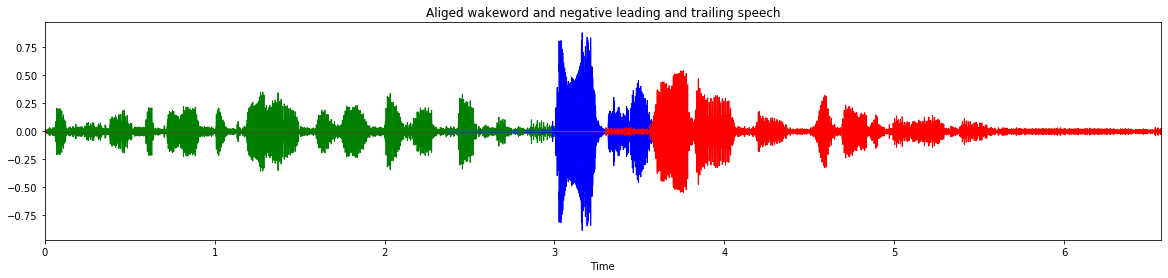

In [18]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(output[:,0]), sr=sr, color='green')
librosa.display.waveplot(np.asfortranarray(output[:,1]), sr=sr, color='blue')
librosa.display.waveplot(np.asfortranarray(output[:,2]), sr=sr, color='red')
plt.title('Aliged wakeword and negative leading and trailing speech')
fig.set_figwidth(20)

In [19]:
# play extracted example
jitter = np.random.choice((np.arange(0,0.25,0.05) * sr).astype(int))
print(jitter/sr)
eg_1 = extract_example(mix, labs[1,1]-jitter)
ipd.Audio(eg_1, rate=sr)

0.1


(201, 249)

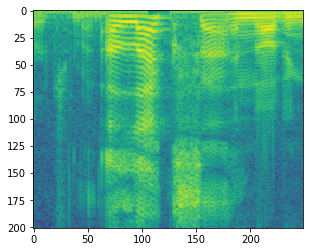

In [20]:
spec = np.abs(librosa.core.stft(eg_1, win_length=(sr // 40), hop_length=(sr // 200), n_fft=(sr // 40)))
plt.imshow(np.log(spec))
spec.shape

### Other features/views of the data

In [21]:
def dct_filters(n_filters, n_input):
    basis = np.empty((n_filters, n_input))
    basis[0, :] = 1.0 / np.sqrt(n_input)

    samples = np.arange(1, 2*n_input, 2) * np.pi / (2.0 * n_input)

    for i in range(1, n_filters):
        basis[i, :] = np.cos(i*samples) * np.sqrt(2.0/n_input)

    return basis

def normalize_0_1(values, M=None, m=None):
    m = m if m is not None else values.min()
    M = M if M is not None else values.max()
    normalized = np.clip((values - m) / (M - m), 0, 1)
    return normalized

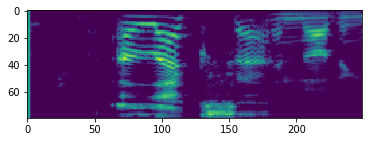

In [22]:
win_length=(sr // 40); hop_length=(sr // 200); n_fft=512; n_mels=80; n_mfcc=40

samples = librosa.effects.preemphasis(eg_1, coef=0.97)
    
mag = np.abs(librosa.core.stft(samples,
    win_length=win_length,
    hop_length=hop_length,
    n_fft=n_fft))

mel_basis = librosa.filters.mel(sr, n_fft, n_mels) 
mel = np.dot(mel_basis, mag)
    
mel_db = librosa.amplitude_to_db(mel)

mfccs = normalize_0_1(np.dot(dct_filters(n_mfcc, mel_db.shape[0]), mel_db))

mel_db = normalize_0_1(mel_db, 35, -55)


plt.imshow(mel_db)

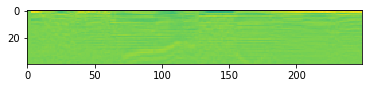

In [23]:
plt.imshow(np.exp(mfccs))

In [24]:
len(samples) // hop_length

248

## Time Altering

Text(0.5, 1.0, 'Lengths in ms of Wakewords')

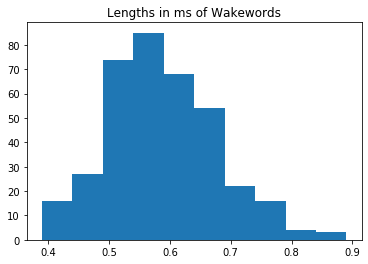

In [972]:
wakeword_lens = [(e-s)/float(sr) for (s,e) in list(positive_metadata.values())]
plt.hist(wakeword_lens);
plt.title('Lengths in ms of Wakewords')

In [973]:
shortest_i = wakeword_lens.index(min(wakeword_lens))

y_fast, _ = sf.read(source_files[shortest_i])
clip_fast = Clip(y_fast, *positive_metadata[source_files_[shortest_i]])

print((clip_fast.end - clip_fast.start) / sr)
ipd.Audio(clip_fast.samples[clip_fast.start: clip_fast.end], rate=sr)

0.39


In [27]:
longest_i = wakeword_lens.index(max(wakeword_lens))

y_slow, _ = sf.read(source_files[longest_i])
clip_slow = Clip(y_slow, *positive_metadata[source_files_[longest_i]])

print((clip_slow.end - clip_slow.start) / sr)
ipd.Audio(clip_slow.samples[clip_slow.start: clip_slow.end], rate=sr)

0.89


By these examples, seems fair to say that wakeword should be between 400 and 900ms.

In [992]:
def time_stretch_to_target(clip, target_len=0.550, sr=sr, tolerance=0.05):
    """
    Don't alter if current length is within tolerance.
    Args:
      clip: of Clip type
      target_len: length in miliseconds that clip content should be
      tolerance: in ms
    """
    cur_len = (clip.end - clip.start)/sr
    if abs(cur_len - target_len) < tolerance:
        return clip
    else:
        time_stretch = cur_len / target_len
        new_samples = pyrb.time_stretch(clip.samples, sr=sr, rate=time_stretch)
        new_start = int(clip.start / time_stretch)
        new_end = int(clip.end / time_stretch)
        return Clip(new_samples, new_start, new_end)

In [993]:
clip_fast_altered = time_stretch_to_target(clip_fast, target_len=0.6)
ipd.Audio(clip_fast_altered.samples[clip_fast_altered.start: clip_fast_altered.end], rate=sr)

In [30]:
clip_slow_altered = time_stretch_to_target(clip_slow, target_len=0.6)
ipd.Audio(clip_slow_altered.samples[clip_slow_altered.start: clip_slow_altered.end], rate=sr)

We will sample from the true distribution with a multinomial

In [31]:
lengths_ms = np.arange(0.4,0.9,0.05)
lengths_counts, _ = np.histogram(wakeword_lens, bins=lengths_ms)
lengths_probabilities = lengths_counts / lengths_counts.sum()
print(lengths_counts)

[16 31 80 73 76 46 26 12  4]


In [32]:
# sample once
lengths_ms[np.random.multinomial(1, lengths_probabilities).tolist().index(1)]

0.6

## Pitch Altering

In [8]:
import amfm_decompy.basic_tools as basic
import amfm_decompy.pYAAPT as pYAAPT

In [9]:
def clip2pitch(clip):
    signal = basic.SignalObj(data=clip.samples[clip.start:clip.end], fs=sr)
    pitchY = pYAAPT.yaapt(signal, frame_length=35.0, tda_frame_length=35.0, f0_min=75, f0_max=600)
    return np.median(pitchY.samp_values[pitchY.vuv])

def clip2pitches(clip):
    signal = basic.SignalObj(data=clip.samples[clip.start:clip.end], fs=sr)
    pitchY = pYAAPT.yaapt(signal, frame_length=35.0, tda_frame_length=35.0, f0_min=75, f0_max=600)
    return pitchY.samp_values[pitchY.vuv]


In [609]:
speakers = [pth.split('/')[0] for pth in list(positive_metadata.keys())]
speakers = list(set(speakers))
file_to_pitches = {}

In [610]:
pitches = []
pitches_and_clips = []
for k, v in positive_metadata.items():
    print('.', end='')
    
    speaker = k.split('/')[0]
    s, e = v
    y, _ = sf.read(os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', k))
    clip = aa.Clip(y, s, e)
    pitch = clip2pitch(clip)
    pitches.append(pitch)
    file_to_pitches[k] = pitch
    pitches_and_clips.append((pitch, clip))


.......................................................................................................................................................................................................................................................

/scratch0/ilya/locDoc/miniconda2/envs/venvtf1p15nb/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch0/ilya/locDoc/miniconda2/envs/venvtf1p15nb/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


..........................................................................................................................

In [611]:
with open('data/alexa.annotated.pitches.json', 'w') as metafile:
    json.dump(file_to_pitches, metafile)

Text(0.5, 1.0, 'Pitches of Wakewords')

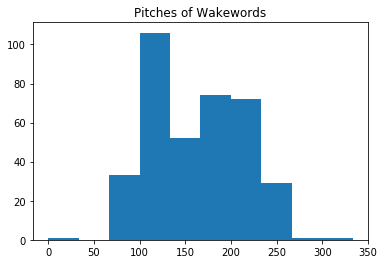

In [13]:
plt.hist(pitches)
plt.title('Pitches of Wakewords')

In [14]:
pitches_bins = np.arange(85,260,18)
pitches_counts, _ = np.histogram(pitches, bins=pitches_bins)
pitches_probabilities = pitches_counts / pitches_counts.sum()
print(pitches_counts)

[43 61 46 24 31 42 55 29 21]


In [15]:
pitches_and_clips_sorted = sorted(pitches_and_clips, key=lambda tup: tup[0])

In [584]:
clip_hi = pitches_and_clips_sorted[-3][1]
print(pitches_and_clips_sorted[-3][0])
clip = clip_hi
ipd.Audio(clip.samples[clip.start: clip.end], rate=sr)

264.4808743169399


In [593]:
clip_lo = pitches_and_clips_sorted[180][1]
print(pitches_and_clips_sorted[180][0])
clip = clip_lo
ipd.Audio(clip.samples[clip.start: clip.end], rate=sr)

160.0


In [618]:
def pitch_shift_to_Hz(clip, cur_Hz, target_Hz=100):
    semitone_shift = 12 * np.log2(target_Hz/float(cur_Hz))
    print(semitone_shift)
    rbargs = dict()
    rbargs.setdefault('--frequency', target_Hz/float(cur_Hz))
    rbargs.setdefault('--tempo', 1.0)
    rbargs.setdefault('-F', '--pitch-hq')
    rbargs.setdefault('--no-lamination', '-q')
    return aa.Clip(pyrb.__rubberband(clip.samples, sr, **rbargs), clip.start, clip.end)
# other options: rbargs={'--time':0.5, '--crisp':4,'-F':'--window-short', '--smoothing':'-q', '--pitch-hq':'-q', '--detector-perc':'-q'}

In [619]:
clip_lo_to_hi = pitch_shift_to_Hz(clip_lo, 160.5, 220)

5.459162716828277


In [623]:
audio = clip_lo_to_hi.samples
print(clip2pitch(clip_lo_to_hi))
ipd.Audio(audio, rate=sr)

216.21621621621622


In [625]:
clip_hi_to_lo = pitch_shift_to_Hz(clip_hi, 264.42, 200)

-4.833975629389715


In [627]:
audio = clip_hi_to_lo.samples
print(clip2pitch(clip_hi_to_lo))
ipd.Audio(audio, rate=sr)

195.38346984363366


In [61]:
def min_unif(p):
    return max(80,p-60)/p
def max_unif(p):
    return min(350,p+60)/p
ps = np.arange(75,275,0.5)
print(np.array([min_unif(p) for p in ps]).min())
print(np.array([min_unif(p) for p in ps]).max())
print(np.array([max_unif(p) for p in ps]).min())
print(np.array([max_unif(p) for p in ps]).max())

0.5714285714285714
1.0666666666666667
1.2185792349726776
1.8


Text(0.5, 1.0, 'Vocal Freq vs Frequency multiplier')

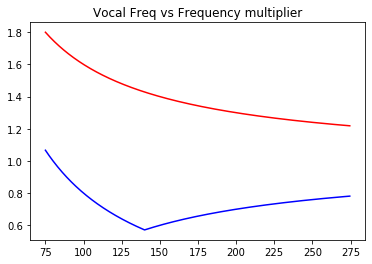

In [63]:
plt.plot(ps, [min_unif(p) for p in ps], color='blue')
plt.plot(ps, [max_unif(p) for p in ps], color='red')
plt.title('Vocal Freq vs Frequency multiplier')

Instead of running base frequency detection for negative speech, should be ok to just generate random freq multiplier between 0.8 and 1.4

## End to End mixing

In [33]:
pitch_shift_opts = np.arange(-3,3.5,0.5).tolist()
silence_1_opts = np.arange(-0.1, 0.2, 0.05).tolist()
silence_2_opts = np.arange(-0.1, 0.2, 0.05).tolist()
loudness_opts = [0.25,0.5,1.0]
augment_opts = list(product(*[pitch_shift_opts, silence_1_opts, silence_2_opts, loudness_opts]))

In [34]:
def augment_audio(p_file, p_start_end, n_file, p_duration, pitch_shift, silence_1, silence_2, loudness):
    """
    Does everything but extraction. Outputs multiple channels.
    
    Args:
      p_duration: in ms
      overlap_1: silence in ms between speech before wakeword and wakeword, if negative there is overlap
      overlap_2: silence in ms between wakeword and speech after wakeword, if negative there is overlap
      pitch_shift: octaves to shift, can be float, -3..+3 is a reasonable range
    """
    sr = 16000
    
    wakeword_samples, _ = sf.read(p_file)
    wakeword = Clip(wakeword_samples, *p_start_end)
    wakeword = time_stretch_to_target(wakeword, target_len=p_duration, sr=sr, tolerance=0.05)
    wakeword = Clip(pyrb.pitch_shift(wakeword.samples, sr=sr, n_steps=pitch_shift), wakeword.start, wakeword.end)
    
    samples_bg, _ = sf.read(n_file)
    lead, trail = extract_other_speech_padding(samples_bg)
    
    output, labs = align_three(lead, wakeword, trail, int(silence_1*sr), int(silence_2*sr))
    
    def get_power(clip):
        return np.sqrt((clip.samples[clip.start:clip.end]**2).sum() / (clip.end-clip.start))
    k = (get_power(lead)+get_power(trail)) / (2*get_power(wakeword))
    
    output[:,1] *= k*loudness
    return output, labs

In [35]:
# pick random examples
pi = random.randint(0,len(source_files)-1)
ni = random.randint(0,len(n_files)-1)

In [36]:
# pick random augment args
args = augment_opts[random.randint(0,len(augment_opts)-1)]
rand_p_duration = lengths_ms[np.random.multinomial(1, lengths_probabilities).tolist().index(1)]
print(rand_p_duration, args)

0.6 (3.0, 0.0, -0.1, 0.5)


In [37]:
# mux it
output, labs = augment_audio(source_files[pi], positive_metadata[source_files_[pi]], n_files[ni], rand_p_duration, *args)

In [38]:
# extract it, with some center jitter
mix = output.mean(axis=1)
jitter = np.random.choice((np.arange(0,0.45,0.05) * sr).astype(int))
print(jitter/sr)
eg_1 = extract_example(mix, labs[1,1]-jitter)
ipd.Audio(eg_1, rate=sr)

0.05


In [39]:
# write to wav
eg_as_ints = (eg_1 * 2**15).astype(np.int16)
audio_segment = pydub.AudioSegment(
    eg_as_ints.tobytes(), 
    frame_rate=sr,
    sample_width=eg_as_ints.dtype.itemsize, 
    channels=1
)
audio_segment.export('/scratch0/ilya/locDownloads/eg.wav', format='wav')

<_io.BufferedRandom name='/scratch0/ilya/locDownloads/eg.wav'>

### Room sim instead of simple averaging

In [40]:
import pyroomacoustics as pra

In [1473]:
# two speakers from above
source1 = output[:,1]
source2 = output[:,[0,2]].mean(axis=1)

In [1080]:
# relevant variables
# large room, small room
bedroom = [4.9, 3.6, 3.5]
large_livingroom = [8.5, 6.7, 3.5]
stpauls = [147, 38, 25]
room_dim_opts = [bedroom, large_livingroom]
# absorption big/small
room_absorption_opts = [0.1,0.8,0.9,1.0] # prefer non-echoey rooms
# closeness of wakeword
wakeword_to_mic_rel_distance_opts = [0.1,0.5,1.0]

room_sim_opts = list(product(*[room_dim_opts, room_absorption_opts, wakeword_to_mic_rel_distance_opts]))

In [1480]:
# Audio mixing with room sim constants
standing_height = 1.65
siting_height = 1.2
speaker_height = standing_height # no big difference
table_height = 0.75
dist_to_wall = 0.6 # 0.3 is one foot

def mix_2_sources(source1, source2, room_dim, room_absorption, source1_to_mic_rel_distance, source2_to_mic_rel_distance=0.5):
    """Use a room sim to mix two sources of audio.
    
    Room Arrangement:
    The room is a cube. and  source1-Mic-source2 is set to be
    an equilateral triangle at first. Then source1 is walked
    towards the mic according to source1_to_mic_rel_distance.
    1.0 means it is not walked to the mic at all. 0.05 means it
    is on top of the mic. The room mixer adjusts the volume
    automatically. With a value of 0.01 source2 is barely audible. 
    
    Args:
        room_dim: [x, y, z] dims in meters of room
        room_absorption: float 0 to 1, 0 is high reflection, extreme
            values are noticible but otherwise is subtle.
        source1_to_mic_rel_distance: float 0 to 1, described above.
        source1: mono audio samples assumed to be already aligned
            with source2 which is assumed to be the same shape.
    Returns:
        mono mixed sound
    """
    corners = np.array([[0,0], [0,room_dim[0]], [room_dim[1],room_dim[0]], [room_dim[1],0]]).T
    height = room_dim[2]
    pos1 = np.array([dist_to_wall, dist_to_wall, speaker_height])
    pos2 = np.array([room_dim[1]-dist_to_wall, dist_to_wall, speaker_height])
    mic_radius = .005
    # when mic array is this small, no big difference since
    # we ignore direction here
    n_mic = 1
    mic_pos = np.array([room_dim[1]/2, room_dim[0], table_height])
    
    pos1 = (1-source1_to_mic_rel_distance)*mic_pos + source1_to_mic_rel_distance*pos1
    pos2 = (1-source2_to_mic_rel_distance)*mic_pos + source2_to_mic_rel_distance*pos2
    
    room = pra.Room.from_corners(corners, fs=16000, absorption=room_absorption, max_order=5)
    room.extrude(height)
    room.add_source(pos1, signal=source1)
    room.add_source(pos2,signal=source2)
    R = pra.circular_2D_array(mic_pos[:2], n_mic, 0, mic_radius)
    R = np.concatenate((R, np.ones((1, n_mic)) * mic_pos[2]), axis=0)
    mics = pra.MicrophoneArray(R, sr)
    room.add_microphone_array(mics)
    
    room.simulate()
    mono_room = np.mean(room.mic_array.signals, axis=0)
    # rescale roomsim to max source, otherwise it is too quiet
    mono_room *= max(source1.max(), source2.max()) / mono_room.max()
    return mono_room
    
    

In [1082]:
mix_settings = random.sample(room_sim_opts, 1)[0]

In [1486]:
# mono_room = mix_2_sources(source1, source2, *mix_settings)
mono_room = mix_2_sources(source1, source2, bedroom, 0.5, 0.1, 0.5)
ipd.Audio(mono_room, rate=sr)

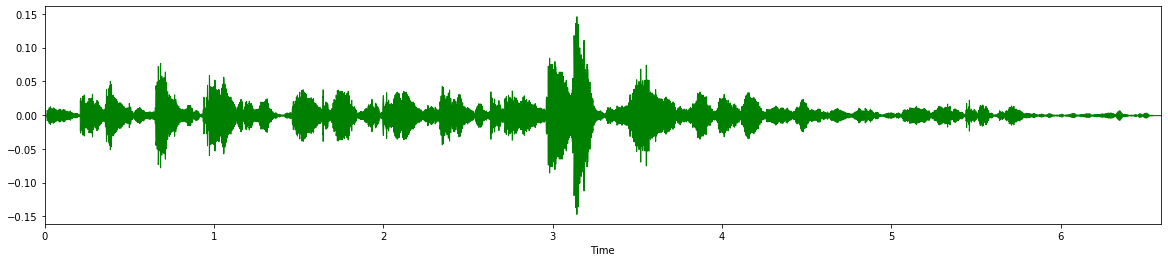

In [1487]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(mono_room), sr=sr, color='green')
fig.set_figwidth(20)

In [1477]:
peak_windowed_dBFS(source1)

-20.433812445326023

In [714]:
z = np.zeros(source1.shape)
mono_room = mix_2_sources(z, source2, stpauls, 0.2, 0.5)
ipd.Audio(mono_room, rate=sr)

In [1078]:
# compare to simple addition
ipd.Audio(output.mean(axis=1), rate=sr)

In [1028]:
timit

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

### Church sim

In [781]:
room_dim = stpauls
room_dim = (0.5 * np.array(room_dim)).astype(int)
room_absorption = 0.5
fs = 41000
source1,_ = sf.read('/scratch0/ilya/locDownloads/voice_recording_03-29-13h00m28.wav')
# source2 = np.zeros(source1.shape)
source2,_ = sf.read('/scratch0/ilya/locDownloads/voice_recording_03-29-13h01m09.wav')
source2 *= 0.25

In [782]:
corners = np.array([[0,0], [0,room_dim[0]], [room_dim[1],room_dim[0]], [room_dim[1],0]]).T
height = room_dim[2]
pos1 = np.array([room_dim[1]/2, room_dim[0]-dist_to_wall, speaker_height])
pos2 = np.array([room_dim[1]/2, dist_to_wall, speaker_height])
mic_radius = .005
# when mic array is this small, no big difference since
# we ignore direction here
n_mic = 1
mic_pos = np.array([room_dim[1]/2, room_dim[0]/2, siting_height])

#pos1 = (1-source1_to_mic_rel_distance)*mic_pos + source1_to_mic_rel_distance*pos1

room = pra.Room.from_corners(corners, fs=fs, absorption=room_absorption, max_order=7)
room.extrude(height)
room.add_source(pos1, signal=source1)
room.add_source(pos2,signal=source2)
R = pra.circular_2D_array(mic_pos[:2], n_mic, 0, mic_radius)
R = np.concatenate((R, np.ones((1, n_mic)) * mic_pos[2]), axis=0)
mics = pra.MicrophoneArray(R, fs)
room.add_microphone_array(mics)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


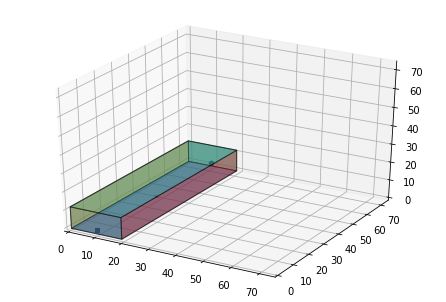

In [783]:
# plot (before simulating) this way
fig, ax = room.plot()
M = max(room_dim[0], room_dim[1])
ax.set_xlim([0, M + 1])
ax.set_ylim([0, M + 1])
ax.set_zlim([0, M ])
plt.show()

In [784]:
room.simulate()
mono_room = np.mean(room.mic_array.signals, axis=0)
mono_room *= 0.25
ipd.Audio(mono_room, rate=fs)

## Negative examples

In [73]:
def align_two(source_a, source_b, b_delay=0):
    """
    Makes a multitrack np.array of the samples in 2 sources.
    
    
    Args:
      sources should all be of Clip type
      source_a is cut at its start, as much trailing content is included as fits
      source_c is cut at its end, as much leading content is included as fits
      b_delay: number samples to delay b
    Returns:
      np.array of output, channels=axis 1. np.array of content start end times, shape 2x2.

    There is the concept of content, track which includes padding for content, and output.

    Turn the source clips into tracks, stick the tracks in the output mux.
    """
    a_len = source_a.end - source_a.start
    b_len = source_b.end - source_b.start
    a_start_in_out = 0
    b_start_in_out = a_start_in_out + a_len + b_delay
    out_len = b_start_in_out + b_len

    output = np.zeros((out_len, 2))
    labels = np.zeros((2, 2), dtype=int)

    # start cutting and fitting
    a_pad_right_len = len(source_a.samples) - source_a.end
    if a_start_in_out + a_len + a_pad_right_len > out_len:
        a_pad_right_len = out_len - (a_start_in_out + a_len)
    a_track = source_a.samples[source_a.start:(source_a.end + a_pad_right_len)]
    output[a_start_in_out:(a_start_in_out + a_len + a_pad_right_len),0] = a_track
    labels[:,0] = [a_start_in_out,a_start_in_out + a_len]

    b_pad_left_len = source_b.start
    if b_start_in_out - b_pad_left_len < 0:
        b_pad_left_len = b_start_in_out
    b_track = source_b.samples[(source_b.start-b_pad_left_len):source_b.end]
    output[(b_start_in_out-b_pad_left_len):(b_start_in_out + b_len), 1] = b_track
    labels[:,1] = [b_start_in_out,b_start_in_out + b_len]
    
    return output, labels

In [85]:
def mix_two_negatives(n_file1, n_file2, output_len, silence, output_advance, loudness):
    """
    Args:
      silence: in ms
      output_advance: in ms. If 0 starts from the second clip.
    """
    a, _ = sf.read(n_file1)
    b, _ = sf.read(n_file2)
    
    _, trail = extract_other_speech_padding(a)
    lead, _ = extract_other_speech_padding(b)
    output, labs = align_two(lead, trail, int(silence*sr))
    
    def get_power(clip):
        return np.sqrt((clip.samples[clip.start:clip.end]**2).sum() / (clip.end-clip.start))
    k = get_power(lead) / get_power(trail)
    output[:,1] *= k*loudness

    mixed = output.mean(axis=1)
    
    s = max(labs[1,0]-int(output_advance*sr), 0)
    e = s + output_len
    return mixed[s:e]

In [86]:
ni1 = random.randint(0,len(n_files)-1)
ni2 = random.randint(0,len(n_files)-1)

In [87]:
mix = mix_two_negatives(n_files[ni1], n_files[ni2], 19840, 0, 0.4, 1.0)

In [1073]:
ipd.Audio(mix, rate=sr)

## Loading audio and spectrogram from tfrecord dataset

In [133]:
# tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v5.0/train/_clean_speech_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/test/val_19840/_clean_speech_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v4g/train_80000/_clean_speech_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/phones/v0/train_48000/_clean_TIMIT_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/phones/v0/val_19840/_clean_TIMIT_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/phones/v0_mel/val_19840/_clean_TIMIT_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v6c/train_80000/_clean_speech_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v6c/val_19840/_clean_speech_00_0000.tfrecord'
tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v6f/train_80000/_clean_speech_00_0000.tfrecord'

# tfrecord_file = '/scratch1/ilya/locDoc/data/phones/v0_spec_hop10_gwn_20dBFS/train_48000/_gwn_TIMIT_00_0000.tfrecord'
# tfrecord_file = '/scratch1/ilya/locDoc/data/phones/v0_spec_hop10_gwn_15dBFS/train_48000/_gwn_TIMIT_00_0000.tfrecord'



In [134]:
spec_h = 256 # 80

In [135]:
examples = []
specs = []
spec_labs = []
audio_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    audio_labs.append(eg_np.features.feature["audio_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break
spec_labs = np.array(spec_labs)

In [138]:
i = random.randint(0,len(examples)-1)

In [182]:
i=0

In [243]:
i += 1

In [244]:
ipd.Audio(examples[i], rate=16000)

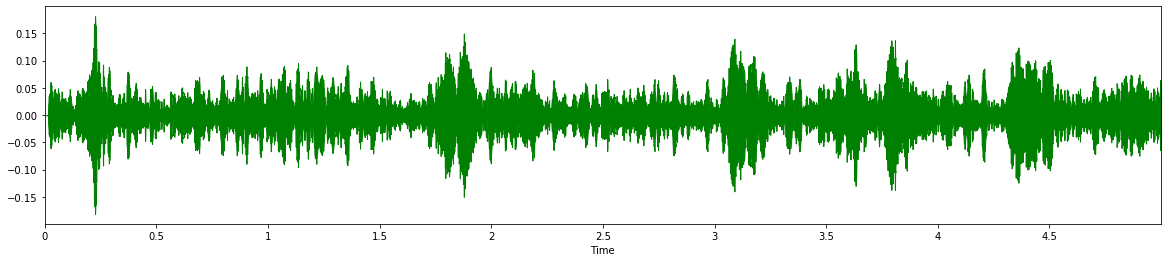

In [217]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(np.array(examples[i]) / 2**15), sr=sr, color='green')
# plt.ylim([-1,1.1])
fig.set_figwidth(20)

1.0


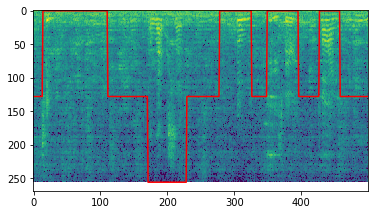

In [218]:
plt.figure()

print(specs[i].max())
img_spec = specs[i]
img_spec = np.log(specs[i]+ 1e-5)
img_spec = (img_spec-img_spec.min()) / (img_spec.max()-img_spec.min())
plt.imshow(img_spec)
plt.plot(((1+spec_labs[i])/2)*spec_h, color='red')

In [1395]:
# write to wav
eg_as_ints = np.array(examples[i]).astype(np.int16)
audio_segment = pydub.AudioSegment(
    eg_as_ints.tobytes(), 
    frame_rate=sr,
    sample_width=eg_as_ints.dtype.itemsize, 
    channels=1
)
audio_segment.export('/scratch0/ilya/locDownloads/eg_before.wav', format='wav')

<_io.BufferedRandom name='/scratch0/ilya/locDownloads/eg_before.wav'>

### Normalize audio

In [1277]:
from librosa.filters import get_window
from scipy.ndimage.filters import maximum_filter1d

In [1139]:
def dBFS(signal):
    return 20*np.log10(np.sqrt((signal ** 2).mean()))

In [1285]:
def peak_windowed_dBFS(signal, rms_window=5):
    win = get_window('hann', rms_window, fftbins=False)
    win = win / win.sum()
    y = np.convolve(signal, win, 'same')
    return dBFS(y.max())

In [1317]:
def scaling_for_dBFS_change(cur_dBFS, target_dBFS=-20):
    """
    Since dBFS can be calculated as a max, or max after
    windowing
    
    Returns:
        a s.t. dBFS(a*signal) == dBFS
    """
    
    # a = np.sqrt(10**(target_dBFS/10.0) / 10**(cur_dBFS / 10.0)  )
    a = 10**( (target_dBFS-cur_dBFS) / 20.0 )
    return a

In [1234]:
train_files = glob.glob(os.path.join('/scratch0/ilya/locDoc/data/TIMIT', 'TRAIN/*/*/*.WAV'))

In [1304]:
rand_file = train_files[random.randint(0,len(train_files)-1)]

In [1418]:
dBFSs = {}
for file in train_files:
    print('.', end='')
    if not file in dBFSs:
        x, _ = sf.read(file)
        x = np.array(x)
        dBFSs[file] = peak_windowed_dBFS(x)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Text(0.5, 1.0, 'Peak dBFS in 5 sample widows in TIMIT')

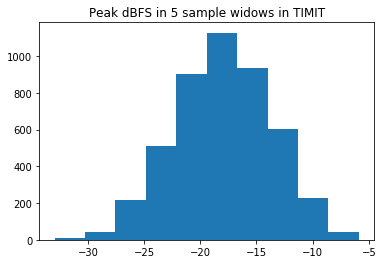

In [1419]:
plt.hist(dBFSs.values());
plt.title('Peak dBFS in 5 sample widows in TIMIT')

In [1305]:
x, _ = sf.read(rand_file)
x = np.array(x)

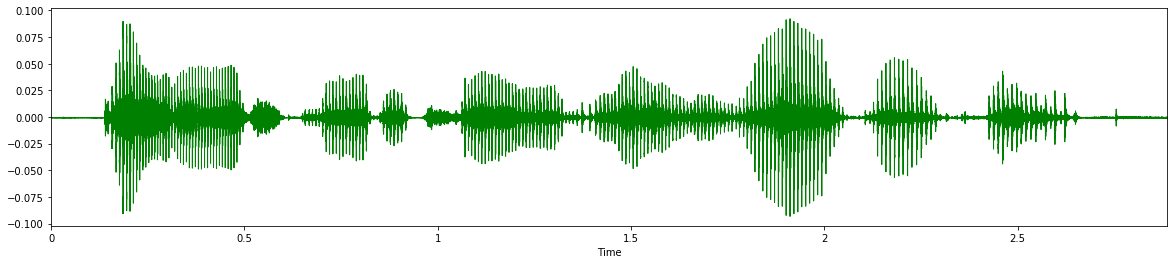

In [1306]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(np.array(x)), sr=sr, color='green')
fig.set_figwidth(20)

In [1320]:
print(dBFS(x))
print(peak_windowed_dBFS(x))

-41.277413238969075
-21.31711684348788


In [1314]:
z = np.zeros(x.shape)
mono_room = mix_2_sources(x, z, bedroom, 0.1, 0.9)
mono_room *= (x.max() / mono_room.max())
ipd.Audio(mono_room, rate=sr)

In [1318]:
print(dBFS(mono_room))
print(peak_windowed_dBFS(mono_room))

-40.457063056704605
-21.015372809456036


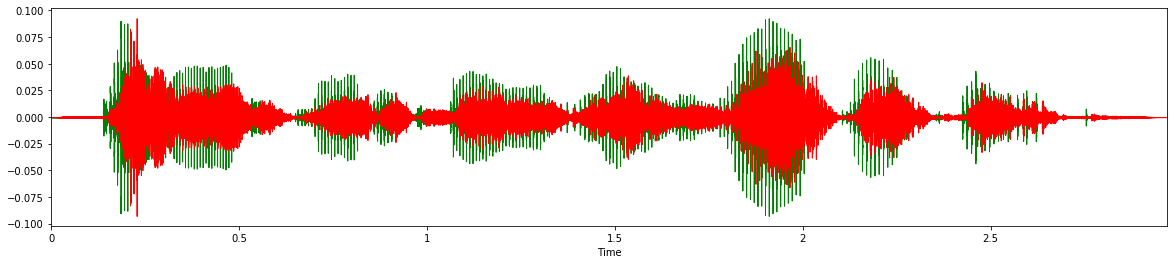

In [1316]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(np.array(x)), sr=sr, color='green')
librosa.display.waveplot(np.asfortranarray(np.array(mono_room * (x.max() / mono_room.max()))), sr=sr, color='red')
fig.set_figwidth(20)

In [1471]:
a = scaling_for_dBFS_change(peak_windowed_dBFS(x,10), -5.0)
print(peak_windowed_dBFS(a*x))

-3.9138913400754616


In [1340]:
print(scaling_for_dBFS_change(peak_windowed_dBFS(x,5), -21.31))
print(scaling_for_dBFS_change(peak_windowed_dBFS(x,10), -22.11))
print(scaling_for_dBFS_change(peak_windowed_dBFS(x,1), -20.66))

1.0008196926507693
0.9999022729395406
0.9996826745389901


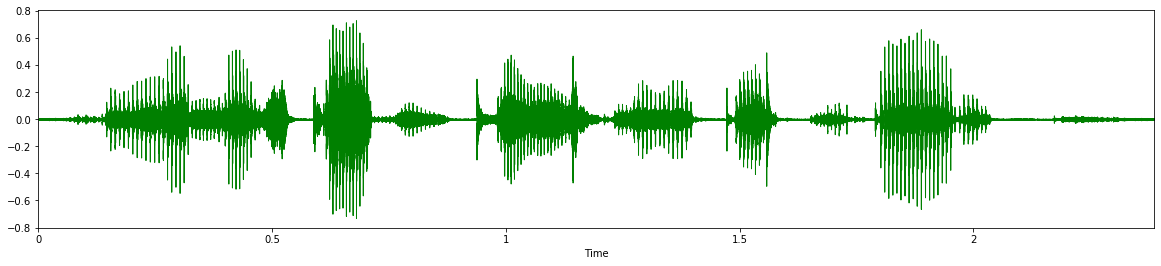

In [1472]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(np.array(a*x)), sr=sr, color='green')
fig.set_figwidth(20)

In [1231]:
rms_window = 1
fft_window = get_window('hann', rms_window, fftbins=False)
fft_window = fft_window / fft_window.sum()
y2 = np.convolve(y, fft_window, 'same')
k = to_dBFS_scaling(y2.max())
dBFS(k*y)

-40.235029825476474

In [1213]:
y2.std()

0.7354291565614023

In [1149]:
a = to_dBFS_scaling(y,-20)

In [1233]:
(k*y).max()

0.09999999999999999

In [1232]:
ipd.Audio(k*y, rate=16000)

### Test out an exponential moving filter

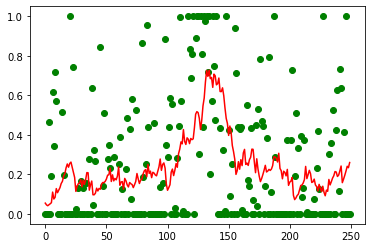

In [402]:
orig = np.array(spec_labs[i][::2]).astype(float)
noise = np.random.normal(0,0.5, len(orig))

orig += noise
orig = np.maximum(np.zeros(noise.shape),orig)
orig = np.minimum(np.ones(noise.shape),orig)

alpha = 0.1
N = 30 # sr * 0.6 // hop_length
myfilt = alpha*((1-alpha)**np.arange(0,N))
myfilt[-1] /= alpha

smoothed = np.correlate(np.array(orig), myfilt, 'same')

plt.plot(orig, 'o',color='green')
plt.plot(smoothed, color='red')

## Label start/end times of keywords

In [985]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [353]:
def chunk_duration_s(chunk, sr=16000):
    return (chunk[1]-chunk[0]) / float(sr)

In [992]:
def source_file_to_start_sample(source_file):
    sound = pydub.AudioSegment.from_file(source_file, format="wav")
    sound_hi = pydub.effects.high_pass_filter(sound, 85)
    sound_mid = pydub.effects.low_pass_filter(sound_hi, 255)
    y = np.array(sound_mid.get_array_of_samples(), dtype=np.float64) / 2**15

    audio_chunks = []
    silence_db = 60
    while silence_db > 0 and (len(audio_chunks) < 1 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() > 0.8 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() < 0.25):
        silence_db -= 5
        audio_chunks = librosa.effects.split(y, top_db=silence_db, frame_length=sr // 40, hop_length=sr // 100)

    if len(audio_chunks) == 0:
        return 0
#     print(silence_db)
    chunk_lens = [chunk_duration_s(c) for c in audio_chunks]
    longest_chunk_i = chunk_lens.index(max(chunk_lens))
    return audio_chunks[longest_chunk_i]

### Interactive start/end time labelling

In [ ]:
source_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa/*/*.wav')

In [1913]:
metadata = {}

In [1904]:
# load source files
with open('data/alexa.annotated.ryan_todo.json') as json_file:
    metadata_todo = json.load(json_file)
source_files = list(metadata_todo.keys())
source_files = [os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', fname) for fname in source_files]

In [1907]:
# Init
ci = -1

In [1915]:
# Next
ci += 1
user_start = None
user_end = None

0
Segment is 520ms long


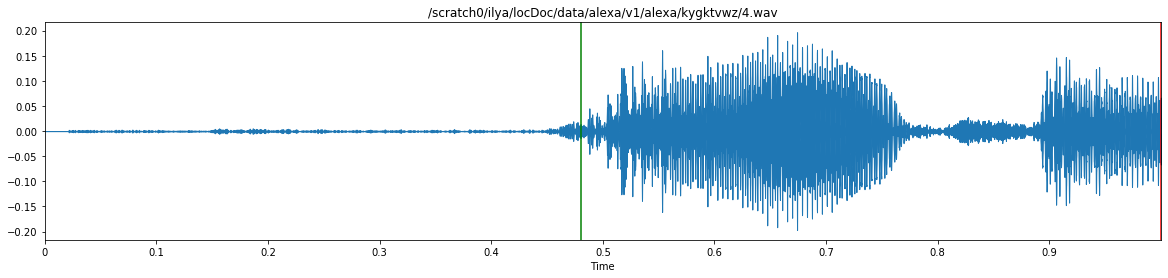

In [170]:
# Test
print(ci)
fig = plt.figure()
y, sr = sf.read(source_files[ci])
try:
    guess_start, guess_end = source_file_to_start_sample(source_files[ci])
except:
    guess_start, guess_end = [0, len(y)]
selected_start = user_start if user_start is not None else guess_start
selected_end = user_end if user_end is not None else guess_end
librosa.display.waveplot(y, sr=sr)
plt.title(source_files[ci])
plt.axvline(x=selected_start/float(sr), c='green')
plt.axvline(x=selected_end/float(sr), c='red')
plt.xticks(np.array(list(range(int(len(y)/float(sr)*10)))) / 10.0)
fig.set_figwidth(20)
print('Segment is %ims long' % int((selected_end-selected_start)/float(sr)*1000) )
# fig
ipd.Audio(y[selected_start:selected_end], rate=sr)

In [1917]:
# Edit (Optional)
user_start = int(0.55 * sr)

In [1918]:
# Edit (Optional)
user_end = int(1.2 * sr)

In [1920]:
# Save in memory
file_id = os.path.join(*source_files[ci].split('/')[-2:])
print(file_id, selected_start, selected_end)
metadata[file_id] = [int(selected_start), int(selected_end)]
len(metadata)

jotbzihj/3.wav 8800 19200


2

In [1921]:
# Write memory to file
with open('data/alexa.annotated.xxx.json', 'w') as metafile:
    json.dump(metadata, metafile)